# CIFAR-10 Image Classification with ResNet and Flask API

This notebook demonstrates how to train a ResNet model on the CIFAR-10 dataset using PyTorch and then deploy the trained model using a Flask API to classify images.




## Importing Libraries

We start by importing the necessary libraries for data handling, model creation, and training.

In [1]:
import io
import time
import torch
import requests
import subprocess
import torchvision

import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms


from PIL import Image
from torchvision.models import resnet50
from IPython.display import clear_output
from flask import Flask, jsonify, request
from torch.cuda.amp import GradScaler, autocast

## Data Preparation

In this section, we download and preprocess the CIFAR-10 dataset.


In [2]:
# Define the transformation for the training and test datasets
# The transformation includes:
# 1. Converting images to PyTorch tensors.
# 2. Normalizing the images with mean and standard deviation of 0.5 for each channel.
transform = transforms.Compose(
    [
        transforms.ToTensor(),  # Convert PIL image or numpy.ndarray to tensor.
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the tensor.
    ]
)

# Download and load the training dataset
# CIFAR-10 dataset will be downloaded (if not already) to './data' directory.
# The training set is used here with the defined transformations.
trainset = torchvision.datasets.CIFAR10(
    root='./data',  # Directory to store the dataset.
    train=True,  # Specify that this is the training set.
    download=True,  # Download the dataset if not already downloaded.
    transform=transform  # Apply the defined transformations.
)

# Create a DataLoader for the training set
# DataLoader helps in batching, shuffling, and loading the data in parallel using multiple workers.
trainloader = torch.utils.data.DataLoader(
    trainset,  # The dataset to load.
    batch_size=1024,  # Number of samples per batch.
    shuffle=True,  # Shuffle the data at every epoch.
    num_workers=64  # Number of subprocesses to use for data loading.
)

# Download and load the test dataset
# CIFAR-10 dataset will be downloaded (if not already) to './data' directory.
# The test set is used here with the defined transformations.
testset = torchvision.datasets.CIFAR10(
    root='./data',  # Directory to store the dataset.
    train=False,  # Specify that this is the test set.
    download=True,  # Download the dataset if not already downloaded.
    transform=transform  # Apply the defined transformations.
)

# Create a DataLoader for the test set
# DataLoader helps in batching and loading the data in parallel using multiple workers.
testloader = torch.utils.data.DataLoader(
    testset,  # The dataset to load.
    batch_size=1024,  # Number of samples per batch.
    shuffle=False,  # Do not shuffle the test data.
    num_workers=64  # Number of subprocesses to use for data loading.
)

# Define the classes in the CIFAR-10 dataset
# CIFAR-10 dataset consists of 10 different classes.
classes = (
    'plane', 'car', 'bird', 'cat',
    'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
)

# Clear output
clear_output()

## Model Definition

Here, we define the ResNet-50 model and modify it to fit the CIFAR-10 dataset.


In [3]:
# Load the ResNet-50 model
# ResNet-50 is a deep residual network with 50 layers.
# This line initializes the ResNet-50 model with pre-trained weights.
net = resnet50(pretrained=True)

# Modify the final fully connected layer to match the CIFAR-10 classes
# The original ResNet-50 model is designed for 1000 classes (ImageNet).
# We replace the final fully connected layer (fc) to output 10 classes for CIFAR-10.
net.fc = nn.Linear(net.fc.in_features, 10)

# Check if GPU is available and move the model to the GPU if it is
# This line checks if CUDA (GPU support) is available.
# If available, it sets the device to the first GPU; otherwise, it defaults to CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move the model to the specified device (GPU or CPU)
net.to(device)

# Clear output
clear_output()


## Training the Model

We train the model using the CIFAR-10 dataset.


In [6]:
# Define the loss function and optimizer
# CrossEntropyLoss is commonly used for classification tasks.
# AdamW is an optimizer that implements the Adam algorithm with weight decay.
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.001)

# Lists to store accuracy values for plotting later
test_acc_list = []
train_acc_list = []

# Initialize the GradScaler for mixed precision training
# Mixed precision training uses both 16-bit and 32-bit floating point types to reduce memory usage and increase speed.
scaler = GradScaler()

# Function to calculate accuracy
# This function computes the accuracy of the model's predictions.
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct / total

# Early stopping parameters
patience = 10  # Number of epochs to wait for improvement before stopping
best_acc = 0.0  # Best accuracy achieved so far
epochs_without_improvement = 0  # Number of consecutive epochs without improvement

# Train the model for 150 epochs
num_epochs = 150  # Number of epochs to train the model
for epoch in range(num_epochs):  # Loop over the dataset multiple times
    start_time = time.time()  # Record the start time of the epoch

    running_loss = 0.0  # Initialize the running loss for the epoch
    correct = 0  # Initialize the count of correct predictions for the epoch
    total = 0  # Initialize the total number of samples processed in the epoch

    # Iterate over the training data
    for i, data in enumerate(trainloader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Move inputs and labels to the GPU if available
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass, backward pass, and optimize using mixed precision
        with autocast():  # Enable mixed precision training
            outputs = net(inputs)  # Forward pass: compute the model output
            loss = criterion(outputs, labels)  # Compute the loss

        # Backward pass and optimization
        scaler.scale(loss).backward()  # Scale the loss and perform backward pass
        scaler.step(optimizer)  # Update model parameters
        scaler.update()  # Update the scaler for the next iteration

        # Update running loss
        running_loss += loss.item()
        total += labels.size(0)  # Update the total number of samples processed
        correct += (torch.max(outputs, 1)[1] == labels).sum().item()  # Update the count of correct predictions

        # Print statistics every 10 mini-batches
        if i % 10 == 9:
            accuracy = correct / total  # Calculate accuracy
            print('[%d, %5d] loss: %.3f accuracy: %.2f%%' %
                  (epoch + 1, i + 1, running_loss / 10, 100 * accuracy))
            running_loss = 0.0  # Reset running loss for the next print interval

    # Calculate and store the training accuracy for the epoch
    train_acc = correct / total
    train_acc_list.append(train_acc)  # Append training accuracy to the list

    # Evaluate the model on the test set
    net.eval()  # Set the model to evaluation mode
    correct = 0  # Initialize the count of correct predictions for the test set
    total = 0  # Initialize the total number of samples processed in the test set

    # Disable gradient computation for evaluation
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the GPU if available
            outputs = net(inputs)  # Forward pass: compute the model output
            loss = criterion(outputs, labels)  # Compute the loss

            _, predicted = torch.max(outputs.data, 1)  # Get the predicted class
            total += labels.size(0)  # Update the total number of samples processed
            correct += (predicted == labels).sum().item()  # Update the count of correct predictions

    test_acc = correct / total  # Calculate test accuracy
    test_acc_list.append(test_acc)  # Append test accuracy to the list
    print(f'Test Accuracy: {100 * test_acc:.2f}%')  # Print test accuracy

    end_time = time.time()  # Record the end time of the epoch
    epoch_duration = end_time - start_time  # Calculate the duration of the epoch
    print(f'Epoch {epoch + 1} completed in {epoch_duration // 60:.0f}m {epoch_duration % 60:.0f}s')  # Print epoch duration

    # Early stopping check
    if test_acc > best_acc:
        torch.save(net.state_dict(), 'best_model.pth')
        best_acc = test_acc
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print('Early stopping')
            break

net.load_state_dict(torch.load('best_model.pth'))

print('Finished Training')  # Print a message indicating the completion of training

[1,    10] loss: 21.099 accuracy: 18.61%
[1,    20] loss: 2.467 accuracy: 14.68%
[1,    30] loss: 2.273 accuracy: 14.12%
[1,    40] loss: 2.254 accuracy: 14.38%
Test Accuracy: 23.81%
Epoch 1 completed in 0m 9s
[2,    10] loss: 2.036 accuracy: 23.49%
[2,    20] loss: 1.936 accuracy: 25.18%
[2,    30] loss: 1.824 accuracy: 26.61%
[2,    40] loss: 1.786 accuracy: 27.93%
Test Accuracy: 37.16%
Epoch 2 completed in 0m 9s
[3,    10] loss: 1.662 accuracy: 36.82%
[3,    20] loss: 1.833 accuracy: 34.48%
[3,    30] loss: 1.697 accuracy: 34.43%
[3,    40] loss: 1.600 accuracy: 35.59%
Test Accuracy: 44.54%
Epoch 3 completed in 0m 9s
[4,    10] loss: 1.482 accuracy: 45.25%
[4,    20] loss: 1.570 accuracy: 43.38%
[4,    30] loss: 1.439 accuracy: 44.59%
[4,    40] loss: 1.371 accuracy: 45.83%
Test Accuracy: 50.74%
Epoch 4 completed in 0m 9s
[5,    10] loss: 1.255 accuracy: 53.96%
[5,    20] loss: 1.289 accuracy: 53.37%
[5,    30] loss: 1.216 accuracy: 54.18%
[5,    40] loss: 1.173 accuracy: 54.95%
Tes

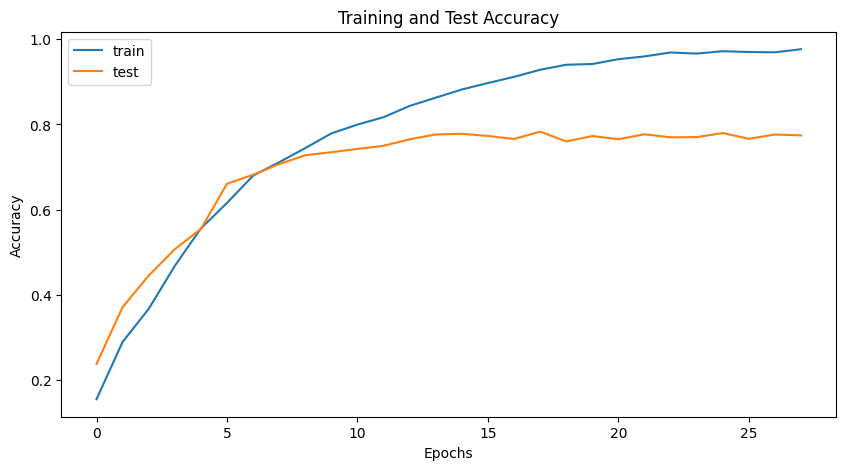

In [7]:
# Plotting the accuracy for training and test sets
plt.figure(figsize=(10,5))
plt.title("Training and Test Accuracy")
plt.plot(train_acc_list,label="train")
plt.plot(test_acc_list,label="test")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [8]:
# Save the trained model
torch.save(net.state_dict(), 'cifar_net.pth')

## Section 5: Creating the Flask API

In this section, we create a Flask API to serve the trained model for image classification.


In [9]:
# Save the Flask app code to a file
with open("flask_app.py", "w") as f:
    f.write("""
from flask import Flask, jsonify, request
import torch
from torchvision.models import resnet50
import torchvision.transforms as transforms
from PIL import Image
import io

# Initialize the Flask application
app = Flask(__name__)

# Load the trained model
model = resnet50(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 10)
model.load_state_dict(torch.load('cifar_net.pth'))
model.eval()

# Define a function to transform the input image
def transform_image(image_bytes):
    my_transforms = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(
                                            (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    image = Image.open(io.BytesIO(image_bytes))
    return my_transforms(image).unsqueeze(0)

# Define a function to get the prediction from the model
def get_prediction(image_bytes):
    tensor = transform_image(image_bytes=image_bytes)
    outputs = model(tensor)
    _, predicted = torch.max(outputs.data, 1)
    return predicted.item()

# Define the prediction endpoint
@app.route('/predict', methods=['POST'])
def predict():
    if request.method == 'POST':
        file = request.files['file']
        img_bytes = file.read()
        class_id = get_prediction(image_bytes=img_bytes)
        return jsonify({'class_id': class_id})

# Run the Flask application
if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000)
    """)

# Clear output
clear_output()

In [10]:
# Start the Flask app in the background
command = ['python3', 'flask_app.py']
process = subprocess.Popen(command)

## Testing the API

To test the API, you can use tools like `curl` or Postman to send a POST request with an image file to the `/predict` endpoint.


In [12]:
# Get the next batch of data
dataiter = iter(testloader)
images, labels = next(dataiter)  # Use the built-in next function

# Loop over the first 10 images in the batch
for i in range(10):
    # Convert the image to a PIL image
    img = transforms.ToPILImage()(images[i])

    # Save the image to a file
    img.save(f"test_image_{i}.jpg")

    # Send a POST request to the Flask API
    response = requests.post("http://0.0.0.0:5000/predict", files={"file": open(f"test_image_{i}.jpg", "rb")})

    # Print the expected class and the response from the API
    expected_class = labels[i].item()
    print(f"Expected class: {expected_class}, API Response: {response.json()}")


Expected class: 3, API Response: {'class_id': 6}
Expected class: 8, API Response: {'class_id': 8}
Expected class: 8, API Response: {'class_id': 1}
Expected class: 0, API Response: {'class_id': 1}
Expected class: 6, API Response: {'class_id': 6}
Expected class: 6, API Response: {'class_id': 6}
Expected class: 1, API Response: {'class_id': 6}
Expected class: 6, API Response: {'class_id': 6}
Expected class: 3, API Response: {'class_id': 6}
Expected class: 1, API Response: {'class_id': 6}
